# Install Dependency

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [2]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696986 sha256=ca8c68a3f5bd2d498d00a8edc00723cfc962002d8bb5978198d4a5cd5358581e
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xhak8i4/wheels/53/dd/70/2de274d6c443c69d367bd6a5606f95e5a6df61aacf1435ec0d
Successfully built object-detection
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0

In [3]:
# Upgrade numpy library
# Note for CC: After running this cell Restart Runtime for the next cell tu run properly
!pip install -U numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


In [10]:
# if there is error in this cell this part from 'from object_detection.builders import model_builder'
# run the above cell !pip install -U numpy and restart the runtime

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import ops as utils_ops

%matplotlib inline

# Fracture Classification Model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('./fracture_classification_model.h5')

1/1 [==============================] - 1s 667ms/step
Predicted class: 0
Confidence: 0.26213548
THE UPLOADED X-RAY IMAGE IS: Fractured


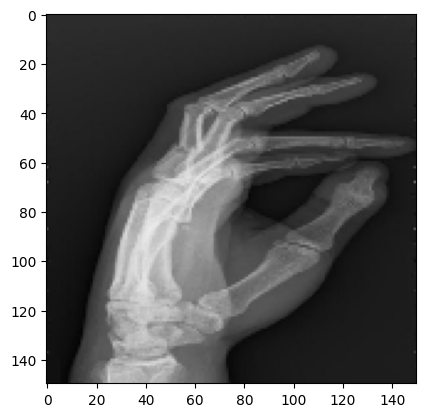

In [ ]:
import PIL
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

img = load_img('/content/test/174_jpg.rf.b255d5b9833f54b9f1489915d4cec83e.jpg', target_size=(150, 150))
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)

predictions = model.predict(x)

# Post-process the predictions
predicted_class = np.argmax(predictions[0])  # Assuming single-class prediction
confidence = predictions[0][predicted_class]

# Print the results
print("Predicted class:", predicted_class)
print("Confidence:", confidence)

a = predictions[0]

if a<0.5:
      op="Fractured"
else:
      op="Normal"
plt.imshow(img)
print("THE UPLOADED X-RAY IMAGE IS: "+str(op))

# Fracture Detection Model

In [6]:
import os
import zipfile

# Extract Object Detection Model

zip_ref = zipfile.ZipFile("/content/fracture_detection_model.zip", 'r')
zip_ref.extractall("/content/new_model")
zip_ref.close()

!mv /content/new_model/content/inference_graph .

[0.57664174 0.45540434 0.35696378 0.319543   0.30694887 0.2689904
 0.2635339  0.243211   0.2017953  0.19797589 0.16670282 0.1651225
 0.15344474 0.13557711 0.12975462 0.12421175 0.12111363 0.11863566
 0.11659592 0.11587288 0.11394285 0.10334546 0.10134249 0.09986013
 0.09929325 0.09897497 0.09804071 0.09710746 0.09666867 0.09666414
 0.09519079 0.09470891 0.09399636 0.09297588 0.09251173 0.09236319
 0.09158579 0.09157611 0.09097262 0.0909685  0.08801956 0.08529975
 0.084994   0.08351994 0.08334314 0.08180095 0.08143215 0.08106472
 0.08035982 0.080107   0.07949641 0.07939545 0.07926013 0.07923377
 0.07888149 0.07677957 0.07614762 0.07569439 0.07565705 0.07536136
 0.07422373 0.07354883 0.07334329 0.07300869 0.07192244 0.07187628
 0.07168345 0.07123155 0.07116836 0.07101957 0.07055525 0.06979797
 0.06968758 0.06945443 0.06923927 0.0689225  0.06849515 0.06827595
 0.06827372 0.06810678 0.0676364  0.06756856 0.06744277 0.06702758
 0.066926   0.06655554 0.06563123 0.06509618 0.06508937 0.064950

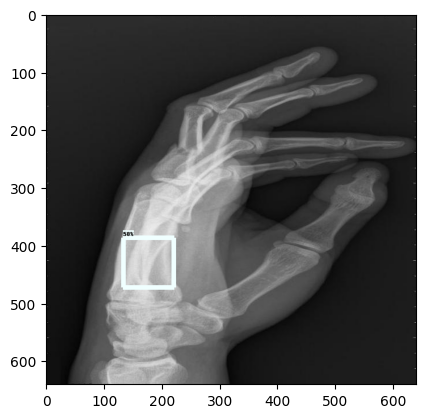

In [17]:
import argparse
from io import BytesIO
import glob

# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile


def load_model(model_path):
    model = tf.saved_model.load(model_path)
    return model


def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: a file path (this can be local or on colossus)

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def detection_output(model, image):
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy()
                   for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with fracture:
    if 'fracture' in output_dict:
        # Reframe the the bbox fracture to the image size.
        detection_fracture_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['fracture'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_fracture_reframed = tf.cast(detection_fracture_reframed > 0.5, tf.uint8)
        output_dict['detection_fracture_reframed'] = detection_fracture_reframed.numpy()

    return output_dict


def run_detection(model, category_index, image_path, output_path):

    image_np = load_image_into_numpy_array(image_path)
    # Actual detection.
    output_dict = detection_output(model, image_np)
    # Visualization of the results of a detection.
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        skip_labels=True,
        max_boxes_to_draw=200,
        line_thickness=8)
    """The existing plt lines do not work on local pc as they are not setup for GUI
        Use plt.savefig() to save the results instead and view them in a folder"""
    plt.imshow(image_np)
    # plt.show()
    # silahkan ubah nama filenya outputnya disini
    plt.savefig("{}/detection_output.png".format(output_path))
    #print(output_dict['detection_scores'])
    for detection in output_dict['detection_scores']:
        if (detection >= 0.5):
            return True
        else:
            return False


model_path = '/content/inference_graph/saved_model'
image_path = '/content/test/174_jpg.rf.b255d5b9833f54b9f1489915d4cec83e.jpg'
output_path = '/content/output'
label_map_path = '/content/bone-fractures_label_map.pbtxt'

detection_model = load_model(model_path)
category_index = label_map_util.create_category_index_from_labelmap(label_map_path, use_display_name=False)
is_detected = run_detection(detection_model, category_index, image_path, output_path)

if (is_detected):
  print("Fracture berhasil terdeteksi")
else:
  print("Fracture gagal dideteksi")